# Project 3 - Part 1



---



# Outline


- [Task 1](#task-1): Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>

<a name="task-1"></a>

# Task 1: Convolutional Neural Networks [(index)](#index-task-1)

Prerequisites

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
from torch.nn import Sequential, CrossEntropyLoss, Conv2d, MaxPool2d, Flatten, Linear, Dropout, BatchNorm2d, ReLU, PReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

Load the Data

In [2]:
b_image_train = np.load('blood_images_train.npy')
b_class_train = np.load('blood_classes_train.npy')

b_image_test = np.load('blood_images_test.npy')
b_class_test = np.load('blood_classes_test.npy')

# Implment a new axis to store channel depth
b_image_train = b_image_train[:,np.newaxis,:,:]
b_image_test = b_image_test[:,np.newaxis,:,:]

Verify Shape of test and training data set

In [3]:
# check shapes of data sets
print('Training data Shape:',b_image_train.shape)
print('Test data Shape:',b_image_test.shape)


# verify test and training class data have expected shapes
assert b_class_train.shape[0] == b_image_train.shape[0]
assert b_class_test.shape[0] == b_image_test.shape[0]


# check class sizes
print('Class sizes Training Data:', np.bincount(b_class_train.squeeze()))
print('Class sizes Test Data:', np.bincount(b_class_test.squeeze()))


Training data Shape: (650, 1, 28, 28)
Test data Shape: (64, 1, 28, 28)
Class sizes Training Data: [200 200 200  50]
Class sizes Test Data: [16 16 16 16]


Implement a dictionary recording class names and class index relations

In [4]:
# dictionary storing class name and class index relation
value_to_type = {0 : "lymphocytes", 1: "platelets", 2 : "neutrophils", 3 : "immature cells"}

# list storing class names
classes = ['lymphocytes', 'platelets', 'neutrophils', 'immature cells']

Split Training Data Set into a Training and Validation Set

In [5]:
np.random.seed(0)

# shuffle data
shuffled_indices = np.random.choice(b_image_train.shape[0], size = int(b_image_train.shape[0]), replace = False)

b_class_train = b_class_train[shuffled_indices]
b_image_train = b_image_train[shuffled_indices]

split_rate = 0.8
the_split = int(0.8 * b_image_train.shape[0])

# split training data into train and validation sets
b_image_train_t = b_image_train[:the_split,:,:,:]
b_class_train_t = b_class_train[:the_split]
b_image_train_v = b_image_train[the_split:,:,:,:]
b_class_train_v = b_class_train[the_split:]

# check split data sets shapes
print('Training set Shape:', b_image_train_t.shape)
print('Validation set Shape:',b_image_train_v.shape)

# check class sizes
print('Class sizes Training set:', np.bincount(b_class_train_t.squeeze()))
print('Class sizes Validation Set:', np.bincount(b_class_train_v.squeeze()))


# verify expected shapes
assert b_class_train_t.shape[0] == b_image_train_t.shape[0]
assert b_class_train_v.shape[0] == b_image_train_v.shape[0]
assert b_class_train_t.shape[0] + b_class_train_v.shape[0] == b_class_train.shape[0]
assert b_class_train_t.shape[0] == b_class_train.shape[0] * 0.8

Training set Shape: (520, 1, 28, 28)
Validation set Shape: (130, 1, 28, 28)
Class sizes Training set: [160 159 161  40]
Class sizes Validation Set: [40 41 39 10]


Implement a function that builds the stated model, has been edited to incoporate dropout from task 1.2

In [6]:
def get_model(x_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, dropout_p, classes):
    """
    CNN model in PyTorch:
    - It features an Adam optimiser and CrossEntropyLoss criterion.

    Parameters:
        x_train: Training data
            (np.array)
            Shape: (N,1,l,h)

        n_filters1: Number of filters to be used in the first convolutional layer
            (int)
    
        k1: Shape of Kernel in the first convolutional layer
            (np.array)
    
        pool_size: MaxPool2d window shape
            (np.array)
    
        stride_pool: Stride of the MaxPool2d sliding window
            (int)
    
        n_filters2: Number of filters to be used in the second convolutional layer
            (int)

        k2: Kernel shape in the second convolutional layer
            (np.array)

        dropout_p: probability of dropping a neuron - if not using dropout set this to 0    
            (float)

        classes: List containing the output classes
            (list)

    Returns:
        model: the model
        
        criterion: the loss function
        
        optimiser: the optimiser(algorithm) used to train the model
    """
    # length  and height after first convolution layer
    l_out_conv1 = x_train.shape[2] - k1[0] + 1 
    h_out_conv1 = x_train.shape[3] - k1[1] + 1 

    # length and height after max pool
    l_out_pool = 1 + (l_out_conv1 - pool_size[0])// stride_pool 
    h_out_pool = 1 + (h_out_conv1 - pool_size[1]) // (stride_pool) 

    # length and height after second convolution layer
    l_out_conv2 = l_out_pool - k2[0] + 1 
    h_out_conv2 = h_out_pool - k2[1] + 1 

    # size before linear layer (after flatten)
        # we flatten the inputs (not the batch_size dimension)
    l_in_linear = l_out_conv2 * h_out_conv2 * n_filters2


    # create the model
    model = Sequential(
        Conv2d(x_train.shape[1], n_filters1, kernel_size=k1),
        
        ReLU(),
        
        MaxPool2d(pool_size , stride = stride_pool),
        
        Conv2d(n_filters1 , n_filters2, kernel_size=k2),

        PReLU(),

        Flatten(),

        # our output should be of the same size as the number of output classes that we want (we can get this from our data set)
            # we want to use softmax to then pick a class depending on the input
        Linear(l_in_linear, len(classes)), 

        Dropout(p = dropout_p),
        
        Softmax(dim = 1), 
    )

    criterion = CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr = 5e-3)

    return model, criterion, optimiser

Initialise and Verify model structure

In [7]:
n_filters1 = 4
k1 = (3,3)
pool_size = (2,2)
stride_pool = 1
n_filters2 = 8
k2 = (3,3)

model0, _ , _  = get_model(b_image_train_t, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, 0, classes)
print(model0)


Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): PReLU(num_parameters=1)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=4232, out_features=4, bias=True)
  (7): Dropout(p=0, inplace=False)
  (8): Softmax(dim=1)
)


Define a function that generates the appropriate DataLoaders to be used in the training loop

In [8]:
def loader_maker(x_train, y_train, x_val, y_val, batch_size):
    """
    Generates DataLoaders to be used in the Training Loop

    Parameters:
        x_train: Training data set

        y_train: Training data set labels

        x_val: Validation data set

        y_val: Validation data set labels

        batch_size: Size of the mini-batches used in each epoch

    Returns:
        train_loader: Training DataLoader

        val_loader: Validation DataLoader
    """

    # Make data to tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val)

    # Creating training and validation datasets
        # stores data in a form correponding to (data, labels)
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

    # Creating corresponding DataLoaders (allows us to iterate over batches of our data)
        # splits our data set into batches of size = batch_size
            # shuffle = true means that after iterating through all the batches, iterating over it another time will have different batches
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

    return train_loader, val_loader

Define a function that conducts the training loop

In [9]:
def training_loop(model, criterion, optimiser,train_loader, val_loader, max_num_epochs=200):
    """
    Training loop

    Parameters:
        model: the model

        criterion: the loss function

        optimiser: the optimiser(algorithm) used to train the model
        
        train_loader: Training DataLoader

        val_loader: Validation DataLoader

        max_num_epochs: Maximum number of epochs

        
    Returns:
        history: a dictionary containing information regarding the trianing process
            training loss
            validation loss
            training accuracy
            validation accuracy

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    # determine how early stopping behaves
        # here we set our max_patience to be 5

    
    for epoch in range(max_num_epochs):

        # These are losses and accuracy associated with each epoch
            # so we compute these for each batch and then average them
                # We then store these values for each epoch to compare how much the model improves per epoch
        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0



        # Training
            # model.train tells the model its training time
        model.train()

        # iterate over the different batches in the training data (each epoch)
        for inputs, labels in train_loader:

            # set the gradients used in the optimisation process to zero as we want to optimise each mini bathc individually
            optimiser.zero_grad() 

            # get the outputs from the current model - used to score the currrent model
                    # SHAPE: (no.data_points, classes)
                        # when predicting we take the class with the max associated value
            outputs = model(inputs)

            # get the 'loss' of the current model on the current batch
            loss = criterion(outputs, labels)

            # compute the current batches contribution to the current epochs training loss
                # we use.item() to take the value from the autograd variable and treat it as its own float
            tr_loss += loss.item()

            # predict the classes of the data and compute the accuracy contribution of the current mini_batch
            # tr_accuracy +=  (torch.max(outputs,dim = 1)[1] == labels).sum().item()/(len(labels)* len(train_loader))
            tr_accuracy +=  (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))
            
            # compute gradients of the loss
            loss.backward()

            # update the parameters of the model
            optimiser.step() 


        # store the current epochs training loss and training accuracy
        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)



        # Validation
            # model.eval tells the model its validation time
        model.eval()

        #we don't need to condsider grads here
            # torch.no_grad() will reduce memory consumption when doing calculations as it ignores grads
        with torch.no_grad():

            # iterate over the different batches in the velidation set
            for inputs, labels in val_loader:

                # get outputs from the current model - used to score the currrent model
                outputs = model(inputs)

                # compute loss using the stored criterion
                loss = criterion(outputs,labels)

                # compute the current batches contribution to the current epochs validation loss
                val_loss += loss.item()

                # predict the classes of the data and compute the accuracy contribution of the current mini_batch
                # val_accuracy += (torch.max(outputs, dim = 1)[1] == labels).sum().item() / (len(labels) * len(val_loader))
                val_accuracy +=(torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 

        # store the current epochs validation loss and validation accuracy
        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
            # print values associated with this epoch
        if (epoch+1)%10 == 0:
            print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")


    return history

Initialise and Train the Model

In [10]:
torch.manual_seed(0)

# set training parameters
max_num_epochs = 200

# set model parameters
n_filters1 = 4
k1 = (3,3)
pool_size = (2,2)
stride_pool = 1
n_filters2 = 8
k2 = (3,3)

# Calling the training loop
model1, criterion, optimiser = get_model(b_image_train_t, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, 0, classes)
train_loader1, val_loader1 = loader_maker(b_image_train_t, b_class_train_t, b_image_train_v, b_class_train_v, batch_size = 64)
history = training_loop(model1, criterion, optimiser, train_loader1, val_loader1, max_num_epochs)

Epoch 10/200, Training loss: 0.9029139147864448, Training accuracy: 84.2013888888889%, Validation loss: 0.8659885923067728, Validation accuracy: 88.02083333333333%
Epoch 20/200, Training loss: 0.8806759847535027, Training accuracy: 86.63194444444444%, Validation loss: 0.8622936209042867, Validation accuracy: 86.97916666666667%
Epoch 30/200, Training loss: 0.8673944075902303, Training accuracy: 88.71527777777779%, Validation loss: 0.8713329434394836, Validation accuracy: 86.45833333333333%
Epoch 40/200, Training loss: 0.8906741274727715, Training accuracy: 85.24305555555556%, Validation loss: 0.9104545513788859, Validation accuracy: 83.33333333333333%
Epoch 50/200, Training loss: 0.8674955500496758, Training accuracy: 87.84722222222221%, Validation loss: 0.8664680123329163, Validation accuracy: 88.02083333333333%
Epoch 60/200, Training loss: 0.8534373309877183, Training accuracy: 89.06250000000001%, Validation loss: 0.8660396337509155, Validation accuracy: 87.5%
Epoch 70/200, Training l

Plot the Learning curve and Accuracy during the training process

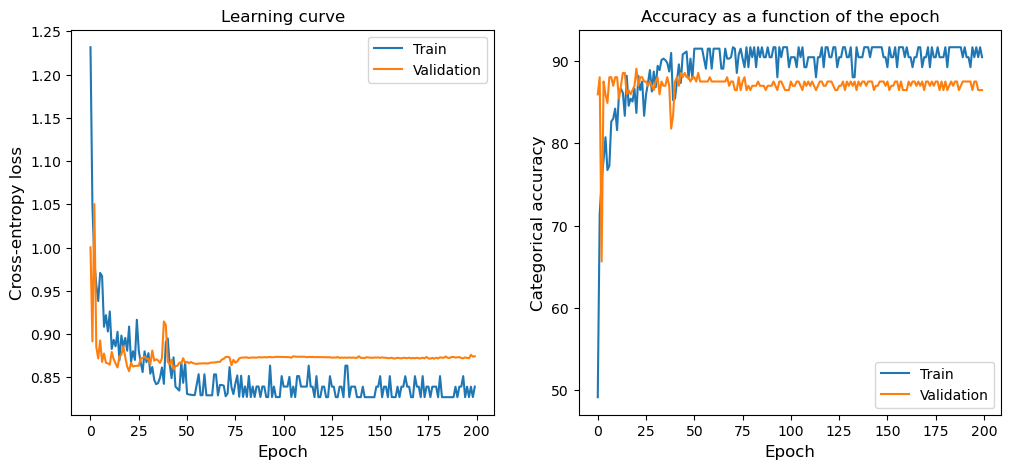

In [11]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Get Classification Accuracy on the Test Set

In [12]:
# Get test set predictions using the trained model
preds1 = model1(torch.tensor(b_image_test, dtype=torch.float32)).detach().numpy() 
print(preds1.shape)

# Get class predictions
pred_class1 = np.argmax(preds1, axis=1)
print('predicted classes of test data:', pred_class1)
print('true classes of test data:', b_class_test.squeeze()) 

# Print the Test accuracy of the model
accuracy1 = 100*np.sum(pred_class1==b_class_test.squeeze())/len(b_class_test)
print('The test accuracy of the CNN model is:', accuracy1)

(64, 4)
predicted classes of test data: [0 2 0 2 2 1 2 1 2 2 2 1 2 0 1 2 2 2 0 2 0 0 2 1 0 0 1 2 0 2 1 2 2 1 2 2 2
 1 2 0 1 2 1 2 2 2 0 2 1 0 1 2 1 1 1 2 1 2 0 2 0 2 2 0]
true classes of test data: [0 2 0 2 2 1 2 1 3 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 2 2 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 1 0 1 3 1 0 1 3 1 3 0 2 0 3 3 0]
The test accuracy of the CNN model is: 73.4375


In [13]:
# check models ability to predict class 4
print(preds1[:,3])

[2.72945515e-16 8.37909185e-16 1.00134647e-17 1.15236185e-18
 9.02746438e-14 6.25472491e-20 1.92888613e-18 1.49205581e-21
 4.08125852e-17 1.10884285e-23 1.15691892e-21 7.57567367e-19
 9.00241588e-18 1.23995311e-15 1.43133046e-15 4.39347453e-25
 1.01121453e-19 8.15943800e-21 3.67536612e-19 4.39296962e-17
 1.69127307e-16 5.79231021e-12 3.73612086e-20 1.89484447e-16
 3.31382409e-19 1.68349109e-16 7.95062498e-21 2.90922612e-21
 1.89569989e-14 3.33434420e-17 1.06476789e-20 5.67145137e-17
 9.91835771e-16 1.04665156e-17 4.59375197e-21 3.49388306e-16
 1.61906447e-12 4.67037821e-16 1.55436042e-20 6.09319851e-18
 2.41626868e-16 1.11808291e-20 1.98253289e-16 5.79545032e-21
 6.69586744e-20 3.32719075e-17 1.47002737e-15 3.25879279e-18
 2.74339928e-14 3.58851306e-20 1.09029319e-19 9.95434578e-20
 1.05532633e-19 1.42824612e-14 2.64807944e-14 1.33123540e-20
 7.89826121e-15 2.63099786e-19 1.58662738e-17 1.64178567e-13
 6.35444223e-16 1.19208326e-20 2.06538915e-23 1.78115202e-20]


<ins> Training Convergence<ins>

The model exhibits relatively fast training convergence, whereby the model converges to a training accuracy and cross entropy loss of approximately 90% and 0.83 respectively. In particular the model attains these values at around epoch 50 (a quarter of the way through the training process) and steadily holds these values until the end of the training process. Our models validation accuracy and cross entropy loss exhibit slightly different behaviour and converge to approximately 86% and 0.87 respectively. While slightly lower than the respective training values, the model attains these values significantly quicker at around epoch 5 (1/40th of the way through the training process) and apart from a noticeable deviation around epoch 40, holds these values steadily throughout the training process. This may be indicative of the model overfitting to the training data as the validation scores don't appear to improve after the aforementioned epoch however the training scores do.

<ins>Classification Accuracy on the Test Set<ins>

Using our trained model to classify the data in the test gives us a classification accuracy on the test set of 73.4375% which is significantly lower than the 86% and 90% exhibited on the validation and training sets above. This further supports our earlier suspicions of the model overfitting to the training data and printing the predictions made by the model appears to provide useful information on the discrepancy between the training/ validation accuracies and the test accuracy. We note that the model exhibits a reduced ability to predict the fourth class (index 3) 'immature cells' due to the low weights assigned to this fourth class. Examining the structure of our data we note that out of the 650 points used to produce the training and validation sets, only 50 of them (around 8%) of them are 'immature cells' whilst the other classes have an equal spread (200 each). Our test data on the other hand, has an equal distribution of all four classes and thus an inability to predict 'immature cells', with a perfect ability to predict the other classes,  will result in a training/ validation accuracy of approximately 92% but a test accuracy of 75%, coinciding with our models values. Due to the imbalanced data in our training set and having not implemented suitable techniques to circumvent this issue, the aforementioned discrepancies in classification accuracy can be explained.

<a name="task-11"></a>

## (1.2) [(index)](#index-task-11)

Dropout was implemented into the get_model function where using dropout_p = 0 is the same as not using dropout

Initialise dropout p values for testing

In [14]:
p_vals = (0.1,0.2,0.5)

Find the best of the given dropout p values

In [15]:
best_dropout_p = 0
best_accuracy = 0

for p in p_vals:
    torch.manual_seed(0)

    model_temp, criterion, optimiser = get_model(b_image_train_t, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, p, classes)
    train_loader1, val_loader1 = loader_maker(b_image_train_t, b_class_train_t, b_image_train_v, b_class_train_v, batch_size = 64)
    history = training_loop(model_temp, criterion, optimiser, train_loader1, val_loader1, max_num_epochs)

    # Take the average validation accuracy of the last 10 epochs to account for slight variations in validation accuracy
    accuracy = np.mean(history['validation_accuracy'][-10:])

    print(p,accuracy)

    # update best p and best accuracy if appropriate
    if accuracy > best_accuracy:
        best_accuracy = accuracy 
        best_p = p

print('The best p value used in the dropout layer of the model from the stated list of p values is:', best_p) 
print('and results in a mean validation accuracy across the last 10 epochs of:' ,best_accuracy)
    

Epoch 10/200, Training loss: 0.9476669629414877, Training accuracy: 79.51388888888889%, Validation loss: 0.8626021941502889, Validation accuracy: 88.02083333333333%
Epoch 20/200, Training loss: 0.9309296939108107, Training accuracy: 80.55555555555556%, Validation loss: 0.8582768241564432, Validation accuracy: 88.54166666666667%
Epoch 30/200, Training loss: 0.8122146725654602, Training accuracy: 94.96527777777777%, Validation loss: 0.8154513835906982, Validation accuracy: 92.70833333333333%
Epoch 40/200, Training loss: 0.7894086837768555, Training accuracy: 96.18055555555556%, Validation loss: 0.8229379057884216, Validation accuracy: 91.66666666666666%
Epoch 50/200, Training loss: 0.7862018744150797, Training accuracy: 95.65972222222223%, Validation loss: 0.8294410308202108, Validation accuracy: 91.66666666666666%
Epoch 60/200, Training loss: 0.7932986285951402, Training accuracy: 95.3125%, Validation loss: 0.8189042210578918, Validation accuracy: 92.70833333333333%
Epoch 70/200, Traini

Train a model using the best dropout p value

In [16]:
torch.manual_seed(0)

model2, criterion, optimiser = get_model(b_image_train_t, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, best_p, classes)
train_loader2, val_loader2 = loader_maker(b_image_train_t, b_class_train_t, b_image_train_v, b_class_train_v, batch_size = 64)
history2 = training_loop(model2, criterion, optimiser, train_loader2, val_loader2, max_num_epochs)

Epoch 10/200, Training loss: 0.9673398799366422, Training accuracy: 77.08333333333333%, Validation loss: 0.8593358794848124, Validation accuracy: 88.54166666666666%
Epoch 20/200, Training loss: 0.9375978045993381, Training accuracy: 80.55555555555556%, Validation loss: 0.8774619897206625, Validation accuracy: 87.5%
Epoch 30/200, Training loss: 0.8379584219720628, Training accuracy: 92.0138888888889%, Validation loss: 0.8174157937367758, Validation accuracy: 92.1875%
Epoch 40/200, Training loss: 0.8416778511471219, Training accuracy: 90.10416666666667%, Validation loss: 0.8241316080093384, Validation accuracy: 91.66666666666666%
Epoch 50/200, Training loss: 0.831368088722229, Training accuracy: 91.14583333333333%, Validation loss: 0.8225763837496439, Validation accuracy: 91.66666666666666%
Epoch 60/200, Training loss: 0.8224990897708468, Training accuracy: 93.05555555555556%, Validation loss: 0.823334276676178, Validation accuracy: 92.1875%
Epoch 70/200, Training loss: 0.904237177636888

Plot the Learning curve and Accuracy for the model trained using the best dropout p value

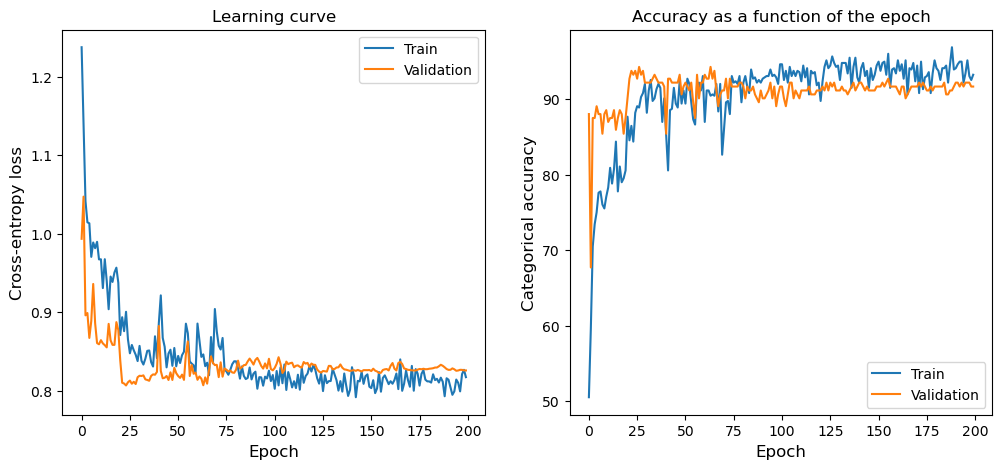

In [17]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history2['training_loss'], label='Train')
plt.plot(history2['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history2['training_accuracy'], label='Train')
plt.plot(history2['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Evaluate classification accuracy of the model trained using the best dropout p value on the test set

In [18]:
# Get test set predictions using the trained model
preds2 = model2(torch.tensor(b_image_test, dtype=torch.float32)).detach().numpy() 
print(preds2.shape)

# Get class predictions
pred_class2 = np.argmax(preds2, axis=1)
print('predicted classes for test data:', pred_class2) # appears to predict the fourth class and the third class
print('true classes for test data:', b_class_test.squeeze()) 

# Print the Test accuracy of the model
accuracy2 = 100*np.sum(pred_class2==b_class_test.squeeze())/len(b_class_test)
print('The test accuracy of the CNN model is:', accuracy2)

(64, 4)
predicted classes for test data: [0 2 0 2 2 1 2 1 2 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 2 2 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 1 0 1 3 1 1 1 3 1 3 0 2 0 3 3 0]
true classes for test data: [0 2 0 2 2 1 2 1 3 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 2 2 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 1 0 1 3 1 0 1 3 1 3 0 2 0 3 3 0]
The test accuracy of the CNN model is: 96.875


<ins>The model<ins>

The model in question was trained by implementing dropout into the CNN and training a model using the best p parameter (0.2) from the stated range of p parameters (0.1,0.2,0.5) where the best p parameter was acquired by taking an average of the validation loss from the last 10 epochs (an average was taken to account for the minor fluctuations in the validation loss). 

<br>

<ins>What is dropout and why does it help resolve the issue of imbalanced data?<ins>

Using Imbalanced Data to train a model can result in the training process producing good scores even when having a reduced ability to predict the minority class. This effectively means the model has overfitted to the training data and would likely not produce good scores when this minority class is not replicated in the test data. Dropout seeks to remedy this by randomly dropping/ignoring layer outputs during the training process. This results in less co-dependency among the neurons as these neurons may be randomly dropped and thus this technique attempts to force the nodes in the network to capture trends within the data in a more individualistic manner. It is important to note that dropout is applied on a layer by layer basis and for our purposes we have applied it after the fully connected layer of our model.

<br>

<ins>Training and Validation Convergence<ins>

This model exhibits relatively fast training convergence however it also exhibits slightly differing behaviour during the training process in comparison to the model from task 1.1. This model converges to a training accuracy and cross entropy loss of 93% and 0.81 respectively and a validation accuracy and cross entropy loss of 91.5% and 0.82 respectively. Immediately we notice that the difference between the validation and training scores is noticeably less for this model than that of task 1.1. Similarly to task 1.1, the training scores converge to their respective values around epoch 50, and the validation scores exhibit rapid improvement within around 5 epochs attaining an accuracy of around 88%; However, where this behaviour deviates from the one from task 1.1 is the validation scores second instance of rapid improvement around epoch 30 where it jumps to around 93% accuracy before converging to the aforementioned 91.5%. We also observe more noticeable fluctuations within the scores of the training process of this model in comparison to the model from task 1.1.

<br>

<ins> Test set Classification Accuracy <ins>

This model produces a classification accuracy on the test set of approximately 97% which is a significant improvement over the model from task 1.1. This would suggest that implementing dropout has allowed the model to better predict the fourth class 'immature cells' and overcomes the issues faced when working with the imbalanced training data mentioned in task 1.1.

<a name="task-11"></a>

## (1.3) [(index)](#index-task-11)

Implement batch Normalisation and edit the get_model and training_loop functions in a manner that allows us to extract the outputs following the first instance of batch normalisation

In [19]:
def get_model2(x_train, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, dropout_p, classes):
    """
    CNN model in PyTorch:
    - It features an Adam optimiser and CrossEntropyLoss criterion.

    Parameters:
    x_train: Training data
        (np.array)
        Shape: (N,1,l,h)

    n_filters1: Number of filters to be used in the first convolutional layer
        (int)
    
    k1: Kernel size in the first convolutional layer
        (np.array)
    
    pool_size: MaxPool2d window size
        (np.array)
    
    stride_pool: Stride of the MaxPool1d sliding window
        (int)
    
    n_filters2: Number of filters to be used in the second convolutional layer
        (int)

    k2: Kernel size in the second convolutional layer
        (np.array)

    dropout_p: probability of dropping a neuron 

    classes: List containing the output classes
        (list)

        
    Returns:
        model_before: the model before and including the first instance of batch normalisation
    
        model_after: the model after the first instance of batch normalisation
    
        criterion: the loss function
    
        optimiser: the optimiser(algorithm) used to train the model

    """
    # length  and height after first convolution layer
    l_out_conv1 = x_train.shape[2] - k1[0] + 1 
    h_out_conv1 = x_train.shape[3] - k1[1] + 1 

    # length and height after max pool
    l_out_pool = 1 + (l_out_conv1 - pool_size[0])// stride_pool 
    h_out_pool = 1 + (h_out_conv1 - pool_size[1]) // (stride_pool) 

    # length and height after second convolution layer
    l_out_conv2 = l_out_pool - k2[0] + 1 
    h_out_conv2 = h_out_pool - k2[1] + 1 

    # size before linear layer (after flatten)
        # we flatten the inputs (not the batch_size dimension)
    l_in_linear = l_out_conv2 * h_out_conv2 * n_filters2



    # create model up to the BatchNorm2D layer
    model_before = Sequential(
        Conv2d(x_train.shape[1], n_filters1, kernel_size=k1),

        # affine = False ensures the gamma and beta parameters aren't learnable
        BatchNorm2d(n_filters1, eps = 1e-5, affine = False)
    )

    # create model after Batchnorm2D layer
    model_after = Sequential(       
        ReLU(),
        
        MaxPool2d(pool_size , stride = stride_pool),
        
        Conv2d(n_filters1 , n_filters2, kernel_size=k2),

        BatchNorm2d(n_filters2, eps = 1e-5, affine = False),

        PReLU(),

        Flatten(),

        # out output should be of the same size as the number of output classes that we want (we can get this from our data set)
            # we want to use softmax to then pick a class depending on the input
        Linear(l_in_linear, len(classes)), 

        Dropout(p = dropout_p),
        
        Softmax(dim = 1), 
    )

    # ensure parameters used in the optimisation process will consider both the before and after parts of the model
    parameters = list(model_before.parameters()) + list(model_after.parameters())

    criterion = CrossEntropyLoss()
    optimiser = torch.optim.Adam(parameters, lr = 5e-3)

    return model_before, model_after, criterion, optimiser

In [20]:
def training_loop2(model_before, model_after, criterion, optimiser,train_loader, val_loader, max_num_epochs=200):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
        model_before: the model before and including the first instance of batch normalisation
    
        model_after: the model after the first instance of batch normalisation
    
        criterion: the loss function
    
        optimiser: the optimiser(algorithm) used to train the model

        train_loader: Training DataLoader

        val_loader: Validation DataLoader

        max_num_epochs: Maximum number of epochs

        
    Returns:
        history: a dictionary containing information regarding the trianing process
            training loss
            validation loss
            training accuracy
            validatiyon accuracy

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    # determine how early stopping behaves
        # here we set our max_patience to be 5

    
    for epoch in range(max_num_epochs):

        # These are losses and accuracy associated with each epoch
            # so we compute these for each batch and then average them
                # We then store these values for each epoch to compare how much the model improves per epoch
        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0



        # Training
            # model.train tells the model its training time
        model_before.train()
        model_after.train()

        # iterate over the different batches in the training data (each epoch)
        for inputs, labels in train_loader:

            # set the gradients used in the optimisation process to zero as we want to optimise each mini bathc individually
            optimiser.zero_grad() 

            # get the outputs from the current model - used to score the currrent model
                    # SHAPE: (no.data_points, classes)
                        # when predicting we take the class with the max associated value
            midputs = model_before(inputs)
            #print(f"Shape after model_before: {midputs.shape}")
            outputs = model_after(midputs)
            #print(f"Shape after model_after: {outputs.shape}")

            # get the 'loss' of the current model on the current batch
            loss = criterion(outputs, labels)

            # compute the current batches contribution to the current epochs training loss
                # we use.item() to take the value from the autograd variable and treat it as its own float
            tr_loss += loss.item()

            # predict the classes of the data and compute the accuracy contribution of the current mini_batch
            # tr_accuracy +=  (torch.max(outputs,dim = 1)[1] == labels).sum().item()/(len(labels)* len(train_loader))
            tr_accuracy +=  (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))
            
            # compute gradients of the loss
            loss.backward()

            # update the parameters of the model
            optimiser.step() 


        # store the current epochs training loss and training accuracy
        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)



        # Validation
            # model.eval tells the model its validation time
        model_before.eval()
        model_after.eval()

        #we don't need to condsider grads here
            # torch.no_grad() will reduce memory consumption when doing calculations as it ignores grads
        with torch.no_grad():

            # iterate over the different batches in the velidation set
            for inputs, labels in val_loader:

                # get outputs from the current model - used to score the currrent model
                midputs = model_before(inputs)
                outputs = model_after(midputs)

                # compute loss using the stored criterion
                loss = criterion(outputs,labels)

                # compute the current batches contribution to the current epochs validation loss
                val_loss += loss.item()

                # predict the classes of the data and compute the accuracy contribution of the current mini_batch
                # val_accuracy += (torch.max(outputs, dim = 1)[1] == labels).sum().item() / (len(labels) * len(val_loader))
                val_accuracy +=(torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 
        
        # store the current epochs validation loss and validation accuracy
        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
            # print values associated with this epoch
        if (epoch+1)%10 == 0:
            print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")


    return history

Train a model implementing batch nomalisation with batch sizes of 64

In [21]:
torch.manual_seed(0)


# Calling the training loop
model_before1, model_after1, criterion, optimiser = get_model2(b_image_train_t, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, 0, classes)
train_loader3, val_loader3 = loader_maker(b_image_train_t, b_class_train_t, b_image_train_v, b_class_train_v, batch_size = 64)
history3 = training_loop2(model_before1, model_after1, criterion, optimiser, train_loader3, val_loader3, max_num_epochs)

Epoch 10/200, Training loss: 0.8197864558961656, Training accuracy: 92.36111111111111%, Validation loss: 0.8308915893236796, Validation accuracy: 91.14583333333333%
Epoch 20/200, Training loss: 0.782918201552497, Training accuracy: 96.18055555555556%, Validation loss: 0.8115547100702921, Validation accuracy: 93.22916666666667%
Epoch 30/200, Training loss: 0.8203510310914781, Training accuracy: 92.53472222222221%, Validation loss: 0.8326059579849243, Validation accuracy: 91.14583333333333%
Epoch 40/200, Training loss: 0.7731733918190002, Training accuracy: 97.04861111111111%, Validation loss: 0.8201029102007548, Validation accuracy: 92.1875%
Epoch 50/200, Training loss: 0.7639455331696404, Training accuracy: 97.91666666666667%, Validation loss: 0.8242765665054321, Validation accuracy: 92.1875%
Epoch 60/200, Training loss: 0.8602290352185568, Training accuracy: 88.19444444444444%, Validation loss: 0.885683019955953, Validation accuracy: 85.41666666666666%
Epoch 70/200, Training loss: 0.7

Plot the Learning curve and Accuracy for the model trained using Batch Normalisation with batch sizes of 64

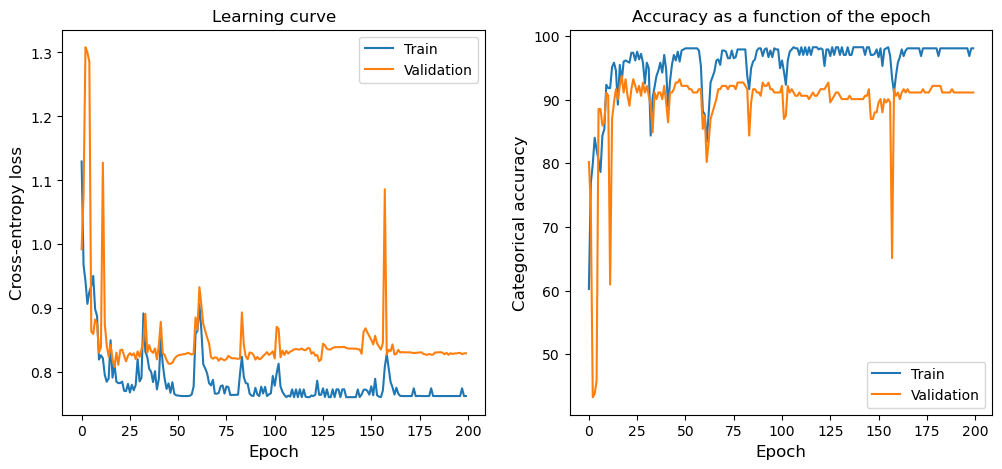

In [22]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history3['training_loss'], label='Train')
plt.plot(history3['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history3['training_accuracy'], label='Train')
plt.plot(history3['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Report Classification Accuracies for the model incorporating Batch Normalisation with batch size 64

In [23]:
# Get test set predictions using the trained model
mids3 = model_before1(torch.tensor(b_image_test, dtype=torch.float32)).detach().numpy() 
preds3 = model_after1(torch.tensor(mids3, dtype=torch.float32)).detach().numpy()
print(preds3.shape)

# Get class predictions
pred_class3 = np.argmax(preds3, axis=1)
print('predicted classes for test data:', pred_class3) # appears to predict the fourth class and the third class
print('true classes for test data:', b_class_test.squeeze()) 

# Print the Test accuracy of the model
accuracy3 = 100*np.sum(pred_class3==b_class_test.squeeze())/len(b_class_test)
print('The test accuracy of the CNN model is:', accuracy3)

(64, 4)
predicted classes for test data: [0 2 0 2 2 1 2 1 2 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 2 2 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 1 0 1 3 1 1 1 3 1 3 0 2 0 3 3 0]
true classes for test data: [0 2 0 2 2 1 2 1 3 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 2 2 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 1 0 1 3 1 0 1 3 1 3 0 2 0 3 3 0]
The test accuracy of the CNN model is: 96.875


Evaluate the normalised outsputs (y) following the first convolutional layer on one batch of the training data and produce a visualisation of the values of one element of y across one of the batches

In [24]:
# print(next(iter(train_loader3)))

# get a single batch from the training data loader
the_chosen_batch = next(iter(train_loader3))
# print(the_chosen_batch[1])

# Evaluate the y values of this batch
y_vals = model_before1(the_chosen_batch[0]).detach().numpy()
# print(y_vals.shape)

# get the y values of a single element of the image
y_vals_single_element = y_vals[:,0,13,13]
# print(y_vals_single_element)

Text(0.5, 0, 'y values')

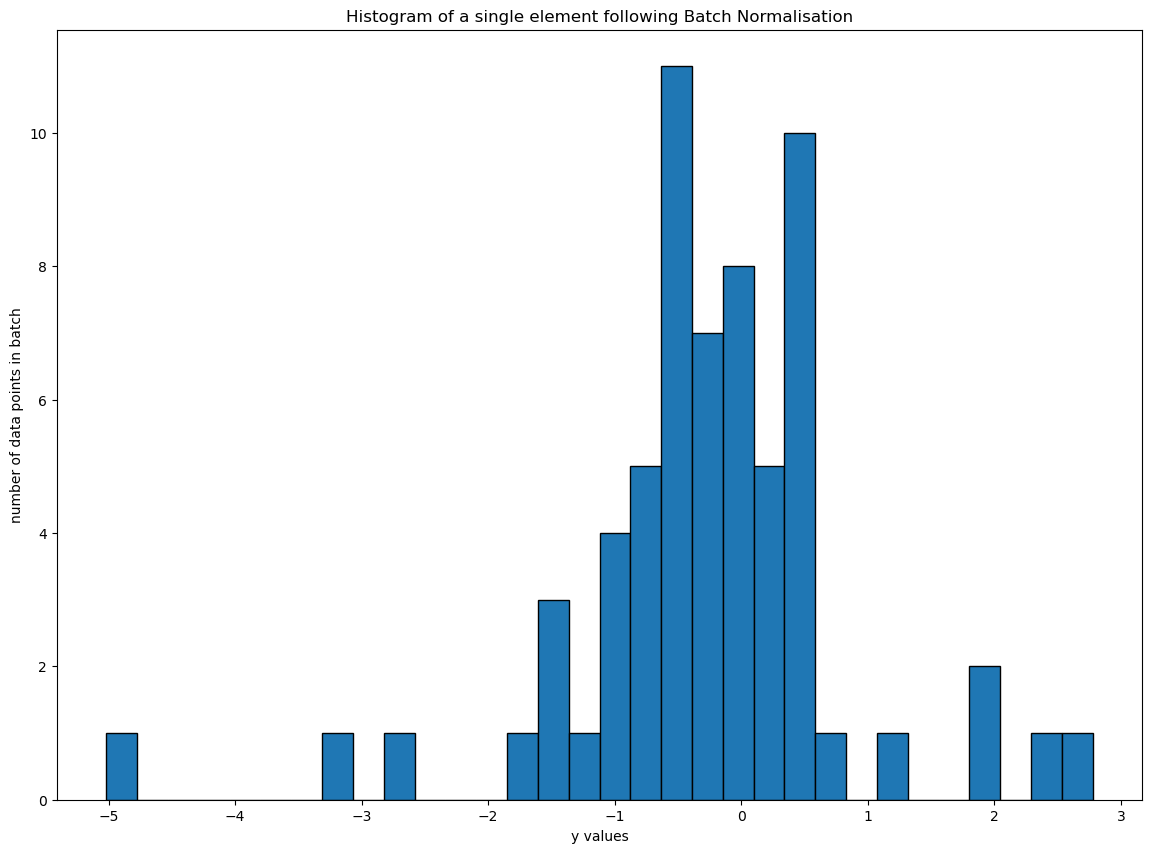

In [25]:
fig, ax = plt.subplots(figsize=(14,10))
plt.title("")
plt.hist( y_vals_single_element, bins = 32 , edgecolor = 'black')
ax.set_title("Histogram of a single element following Batch Normalisation")
ax.set_ylabel('number of data points in batch')
ax.set_xlabel('y values')

Repeat training using batch size of 128

In [26]:
torch.manual_seed(0)


# Calling the training loop
model_before2, model_after2, criterion, optimiser = get_model2(b_image_train_t, n_filters1, k1, pool_size, stride_pool, n_filters2, k2, 0, classes)
train_loader4, val_loader4 = loader_maker(b_image_train_t, b_class_train_t, b_image_train_v, b_class_train_v, batch_size = 128)
history4 = training_loop2(model_before2, model_after2, criterion, optimiser, train_loader4, val_loader4, max_num_epochs)

Epoch 10/200, Training loss: 0.884213101863861, Training accuracy: 86.09374999999999%, Validation loss: 0.9817352890968323, Validation accuracy: 85.15625%
Epoch 20/200, Training loss: 0.8530778050422668, Training accuracy: 89.375%, Validation loss: 0.8467441499233246, Validation accuracy: 89.0625%
Epoch 30/200, Training loss: 0.8161491274833679, Training accuracy: 93.90625000000001%, Validation loss: 0.9298112690448761, Validation accuracy: 90.234375%
Epoch 40/200, Training loss: 0.7944348692893982, Training accuracy: 95.78125%, Validation loss: 0.8146067559719086, Validation accuracy: 92.578125%
Epoch 50/200, Training loss: 0.7714673042297363, Training accuracy: 97.1875%, Validation loss: 0.8053918480873108, Validation accuracy: 94.140625%
Epoch 60/200, Training loss: 0.8273848533630371, Training accuracy: 91.71875%, Validation loss: 1.1235955357551575, Validation accuracy: 60.15625%
Epoch 70/200, Training loss: 0.7947312593460083, Training accuracy: 94.84375%, Validation loss: 0.8157

Plot the Learning curve and Accuracy for the model trained using Batch Normalisation with batch sizes of 128

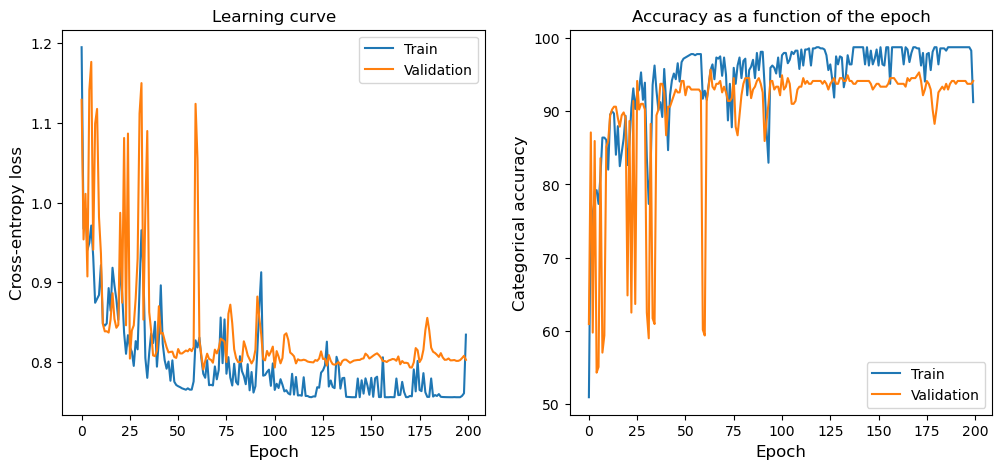

In [27]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history4['training_loss'], label='Train')
plt.plot(history4['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history4['training_accuracy'], label='Train')
plt.plot(history4['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Report Classification Accuracies for the model incorporating Batch Normalisation with batch size 128

In [28]:
# Get test set predictions using the trained model
mids4 = model_before2(torch.tensor(b_image_test, dtype=torch.float32)).detach().numpy() 
preds4 = model_after2(torch.tensor(mids4, dtype=torch.float32)).detach().numpy()
print(preds4.shape)

# Get class predictions
pred_class4 = np.argmax(preds4, axis=1)
print('predicted classes for test data:', pred_class4) # appears to predict the fourth class and the third class
print('true classes for test data:', b_class_test.squeeze()) 

# Print the Test accuracy of the model
accuracy4 = 100*np.sum(pred_class4==b_class_test.squeeze())/len(b_class_test)
print('The test accuracy of the CNN model is:', accuracy4)

(64, 4)
predicted classes for test data: [0 2 0 2 2 1 2 1 3 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 0 3 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 0 0 1 3 1 0 1 3 1 3 0 2 0 3 3 0]
true classes for test data: [0 2 0 2 2 1 2 1 3 3 3 1 3 0 1 3 2 3 0 2 0 0 3 1 0 0 1 3 0 2 1 2 2 1 3 2 2
 1 3 0 1 2 1 3 2 2 0 2 1 0 1 3 1 0 1 3 1 3 0 2 0 3 3 0]
The test accuracy of the CNN model is: 95.3125


<ins>What is Batch Normalisation?<ins>

Batch Normalisation is the process of normalising the inputs to a layer with respect to the current batch being passed through it so that they now have mean a of 0 and standard deviation of 1. This technique can be employed to tackle the covariate shift experienced by passing an input through the model. Note that when testing the model it instead uses a running mean/variance that is calculated during the training process instead of using the mean and  standard deviation of the test points.

<br>

<ins> Test Set Classification Accuracies <ins>

The model trained using batch sizes of 64 produced a classification accuracy on the test set of approximately 97% whilst the model trained using batch sizes of 128 produced a classification accuracy on the test set of approximately 95%. This would suggest that implementing batch normalisation has allowed the model to better predict the fourth class 'immature cells' and overcomes the issues faced when working with the aforementioned imbalanced data much like the model from task 1.2. In particular we note that using a batch size of 64 results in the same classification accuracy as the model from task 1.2 while using a batch size of 128 produces a slightly lower classification accuracy. It should be noted that in all such instances the models above perform significantly better (over 20% higher accuracy) when compared to the model from task 1.1 due to the aforementioned difficulties in predicting the minority class 'immature cells'. From the earlier explanation regarding Batch Normalisation, one would assume that using larger batch sizes would result in a better model, as the mean and standard deviation computations would likely be more reflective of the true population mean and standard deviation; However, our models show that using a smaller batch size of 64 produces a model that is slightly more accurate in predicting the test data than when using a larger batch size of 128. It should be noted that this improvement is marginal and could likely be attributed to the randomness associated with the preparation of the data and the initialisation of the model. However, an alternative explanation may stem from knowing that the variance of the gradients computed during the training loop is directly related to the batch sizes used, where increasing batch size has a similar effect to decreasing the learning rate. The effects of this may potentially explain why using a batch size of 64 took approximately 25 epochs until the model attained the training accuracy it converged to, whilst using a batch size of 128 took approximately 50 epochs until the model attained the training accuracy it converged to.


<a name="task-11"></a>

## (1.4) [(index)](#index-task-11)

Define a function that computes cohens kappa metric

In [29]:
def kappa_metric(y_assignments1, y_assignments2):
    """
    Inputs:
        y_assignments1: First set of y assignments

        y_assignments2: Second set of y assignments


    Outputs:
        cohens_kappa_metric: the computed metric for the two sets of assignments

    """
    # ensure dimensions are as expected
    y_assignments1 = y_assignments1.squeeze()
    y_assignments2 = y_assignments2.squeeze()

    # assuming y_assignments2 assigns points to every possible class
    bins = len(np.unique(y_assignments2))

    # compute the empirical probability (p_observed)
    p_empirical = np.sum(y_assignments1 == y_assignments2) /len(y_assignments1)
    # print(p_empirical)

    # compute the chance probability (p_expected)
    p_chance = np.sum(np.bincount(y_assignments1, minlength = bins)* np.bincount(y_assignments2, minlength = bins))/ len(y_assignments1)**2
    # print(p_chance)

    cohens_kappa_metric = (p_empirical - p_chance)/(1- p_chance)

    return cohens_kappa_metric


In [30]:
kappametric1 = kappa_metric(pred_class1,b_class_test)
print(kappametric1)

0.6458333333333334


<ins> Explanation of Cohen's Kappa Metric<ins>

Cohen's Kappa metric can be interpreted as a measure of how well two sets of categorical assignments regarding the same data align with one another. It does this by considering the empirical probability of the two assignments agreeing (i.e: how many of the pairs of assignments agree compared to how many data points need to be assigned as a whole) adjusted to account for the probability that given the number of points assigned to each class, what's the probability of points agreeing by pure chance. By convention we call the empirical probability the observed probability and the probability of points agreeing by chance is called the expected probability.

To better understand this second probability we consider an example: Consider 10 data points each assigned to two classes. The first assignment has 3 data points in class 1 and 7 data points in class 2 whilst the second assignment has 7 data points in class 1 and 3 data points in class 2. Here we can get the probability of points agreeing by pure chance by considering $P(\text{assignment 1 assigns a point to class 1}\cap \text{assignment 2 assigns a point to class 1}) + P(\text{assignment 1 assigns a point to class 2}\cap \text{assignment 2 assigns a point to class 2})$. By using empirical probabilities $P(\text{assigned to class 1}) = \frac{\text{no of points in class 1}}{\text{no. of points in total}}$ and assuming the two assignments are independant we have that this computation can be expressed as: $$P(\text{assignment 1 assigns a point to class 1})P(\text{assignment 2 assigns a point to class 1}) + P(\text{assignment 1 assigns a point to class 2})P(\text{assignment 2 assigns a point to class 2}) = 0.3 \cdot 0.7 + 0.7\cdot 0.3$$

Cohen's Kappa metric is calculated by comparing these two probabilities (empirical and chance) and then normalising (to account for the reduced maximum probability as a result of subtracting the chance probability) to get a score less than or equal to 1 where higher alignment in the two assignments would result in scores closer to 1.

<br>


*We now work towards implementing the computation of the macro F1 score*

Implement functions computing confusion matrix values for a given class

In [31]:
def get_tp_tn_fp_fn(y_test, y_pred, class_label):
    """function that returns the tp, tn, fp, fn for a given class
    
    Inputs:
        y_test: vector of true class labels
            Shape: (N2,)

        y_pred: vector of predicted class labels
            Shape: (N2,)

        class_label: The class that you want to treat as THE class (i.e: the true class with other classes treated as the negative class) with the tp,fp,tn,fn calculated based on this fixed class
            Shape: 1
            (int)
        
            
    Outputs: 
        return: 
            tp: the no. of true positives for this class
                (int)

            tn: the number of true negatives for this class
                (int)

            fp: the number of false positives for this class
                (int)

            fn: the number of false negatives for this class
                (int)
    """

    tp = np.sum((y_test==class_label) & (y_pred==class_label))

    tn = np.sum((y_test!=class_label) & (y_pred!=class_label))

    fp = np.sum((y_test!=class_label) & (y_pred==class_label))

    fn = np.sum((y_test==class_label) & (y_pred!=class_label))
    
    return tp, tn, fp, fn

Implement a function computing metrics

In [32]:
# get the potatoes
def get_potatoes(y_test, y_pred, class_labels, print_metrics = False):
    """
    Inputs:
        y_test: Data points true labels for testing set
            Shape: (N2,)

        y_pred: Data points predicted labels for testing set
            Shape: (N2,)

        class_labels: a list storing the labels of the different classes
            Shape: (number of classes)

    Outputs:
        potatoes: a dictionary containing relevant metrics
    """

    # initialise values
    macro_precision = 0
    macro_accuracy = 0
    macro_recall = 0
    macro_specificity = 0
    macro_f1_score = 0
    class_weighted_precision = 0
    class_weighted_accuracy = 0
    class_weighted_recall = 0
    class_weighted_specificity = 0
    tp_sum = 0
    fp_sum = 0
    tn_sum = 0
    fn_sum = 0

    # compute weights to be used in class weighted predictions
    weights = np.bincount(y_test)/len(y_test)

    # loop over the different classes
        # as confusion matrix outputs are class specific
            # and recorded values can be adjusted according to class size or weights etc..
    for class_label in class_labels:

        # compute confusion matrix values for current class
        tp, tn, fp, fn = get_tp_tn_fp_fn(y_test, y_pred, class_label)

        # compute current class measures
            # account for scenarios where the measures should be assigned a value of 0
        class_accuracy = (tp+tn)/(tp+tn+fp+fn) 
        
        if tp+fp == 0:
            class_precision = 0
        else:
            class_precision = tp/(tp+fp) 
        
        if tp+fn == 0:
            class_recall = 0
        else:
            class_recall = tp/(tp+fn)
        
        class_specificity = tn/(tn+fp)


        #start computing macro measures
            # add contribution of current class to macro measures
                # account for scenarios where the contribution from the current class should be 0
        macro_accuracy += class_accuracy
        macro_precision += class_precision
        macro_recall += class_recall
        macro_specificity += class_specificity
        if class_precision + class_recall != 0:
            macro_f1_score += 2 * (class_precision * class_recall)/(class_precision + class_recall)


        # track totals to be used in micro calculations after loops completion
        tp_sum += tp
        fp_sum += fp
        tn_sum += tn
        fn_sum += fn


        # add contribution of current class to class weighted measures
        class_weighted_precision += class_precision*weights[class_label]
        class_weighted_accuracy += class_accuracy*weights[class_label]
        class_weighted_recall += class_recall * weights[class_label]
        class_weighted_specificity += class_specificity * weights[class_label]

    # finish computing macro measures
        # divide by number of classes to normalise
    macro_accuracy /= len(class_labels)                        
    macro_precision /= len(class_labels)
    macro_recall /= len(class_labels)
    macro_specificity /= len(class_labels)
    macro_f1_score /= len(class_labels)

    #compute micro
    micro_accuracy = np.sum(y_test==y_pred)/len(y_test)  
    micro_precision = tp_sum/(tp_sum+fp_sum)
    micro_recall = tp_sum/(tp_sum + fn_sum)
    micro_specificity = ... ##################################################

    if print_metrics == True:
        print(f'macro precision = {macro_precision}')
        print(f'micro precision = {micro_precision}')
        print(f'class weighted precision = {class_weighted_precision}')
        print(f'macro accuracy = {macro_accuracy}')
        print(f'micro accuracy = {micro_accuracy}')
        print(f'class weighted accuracy = {class_weighted_accuracy}')
        print(f'macro recall = {macro_recall}')
        print(f'micro recall = {micro_recall}')
        print(f'class weighted recall = {class_weighted_recall}')
        print(f'macro specificity = {macro_specificity}')
        print(f'micro specificity = {micro_specificity}')
        print(f'class weighted specificity = {class_weighted_specificity}')

    potatoes = {
        'macro precision' : macro_precision, 
        'macro accuracy':macro_accuracy,
        'macro recall': macro_recall,
        'macro specificity':macro_specificity,
        'macro f1 score': macro_f1_score,
        'micro precision': micro_precision,
        'micro accuracy': micro_accuracy,
        'micro recall': micro_recall,
        'micro specificity': micro_specificity,
        'class weighted precision': class_weighted_precision,
        'class weighted accuracy': class_weighted_accuracy,
        'class weighted recall': class_weighted_recall,
        'class weighted specificity': class_weighted_specificity

        }

    return potatoes

In [33]:
potatoes = get_potatoes(b_class_test.squeeze(), pred_class1.squeeze(), np.arange(4), print_metrics = False)

print('The macro f1 score of the task 1.1 model on the test set is:',potatoes['macro f1 score'])
print('The accuracy of task 1.1 model on the test set is:',accuracy1)
print('The Cohens Kappa Metric of the task 1.1 model on the test set is:',kappametric1)

The macro f1 score of the task 1.1 model on the test set is: 0.6510263929618768
The accuracy of task 1.1 model on the test set is: 73.4375
The Cohens Kappa Metric of the task 1.1 model on the test set is: 0.6458333333333334


<ins> Comparing Accuracy, Macro F1 score and Cohen's Kappa Metric<ins>

Accuracy measures the proportion of data that is correctly classified by the model. F1 score rewards models with a good balance of precision(measures how many of the models positive predictions are actually positive) and recall(measures how many of the positive data points we manage to correctly predict) and is thus useful when attempting to score imbalanced data sets as it penalises trading either of these metrics for the other one. Note however, that our test data has equal class distribution and thus this advantage is less useful for our purposes. Cohen's Kappa Metric measures how well two sets of assignments agree with one another, for our purposes we compare the true classes to the predicted classes. Here a score of 1 denotes perfect agreement between the classes while a score of 0 denotes the two sets of assignments agree to the extent that one would assume if both models were randomly assigning the classifications to the data points. It should also be noted that Cohen's Kappa Metric utilises accuracy as the observed probability when comparing a predicted assignment to the true assignments.

Considering the scores of the model from task 1.1 we observe that its' Macro F1 score is 0.6510, its' Cohen's Kappa Metric with the true labels is 0.6458 and its accuracy when predicting the test set is 73%. All of these scores suggest the model performs moderately well albeit not well enough to be good, and our understanding from task 1.1 further supports this due to the models inability to predict the training data minority class 'immature cells'. This results in 0.25 point deduction to the Macro F1 Score (as the 'immature cells' class contribution will be 0) and a 25% deduction to the models accuracy (as 25% of the test sets data belongs to the 'immature cells' class) and Cohen's Kappa Metric is similarly affected due to its incorporation of accuracy in its calculation (through the observed probability). Comparing the value of the scores themselves we see that Cohen's Kappa Metric and the Macro F1 Score yield similar values whilst Accuracy produces a higher value. However, it is important to note the difference in the interpretations between these values. As an example, an accuracy of 0- would tell us that there is no shared class assignments between the models predictions and the true classes whilst a Cohen's Kappa Metric of 0 would tell us that the number of shared class assignments between the model and the true classes is exactly the amount that would be expected assuming these assignments were allocated at random (given that the number of points in each class for each assignment is fixed).